# Predicting Solar Flares from Time Series of Magnetic Parameters

Jing Luan (jingluan.xw@gmail.com)

Collaborators: Sankalp Gilda @ U of Florida, Yuan-Sen Ting @ IAS

# Introduction 

Solar flares eject high-energy particles into space which would lead to severe damages to space equipments and injuries to astronauts. Predicting solar flares, or space weather forecast in general, would help avoid those damages. It is like weather forecast which is playing an essential role for all kinds of human activities on the earth. 

* Goal: Our goal is to predict whether there will be solar flares within the next 24 hours given the *time series* of 25 solar magnetic parameters. The time series cover 12 hours of time and are downloaded from [the 2019 IEEE BigData Cup Challenge](https://www.kaggle.com/c/bigdata2019-flare-prediction/data).

* Method: Our method is based on Long Short Term Memory (LSTM) network, which is currently the state-of-art model dealing with time series. We design two different models. One model includes two LSTM layers. The other model includes one Bidirectional LSTM layer followed by a Self Attention layer. 

* Result: The F1 score, a metric taking into account of both prediction sensitivity and precision, is chosen to evaluate our models. Both models reach F1 score about 0.95.


### Importing Packages
Brief comments are provided for why we need these packages.

In [9]:
# Start with importing packages, some explanations are provided.
# to suppress future warning from tf + np 1.17 combination.
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
#runtimewarning is from powertransformer
warnings.filterwarnings('ignore',category=RuntimeWarning)

# to avoid dividing by zero
epsilon = 1e-5
import numpy as np 
import pandas as pd 
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

# Feature Curation (Time-Consuming Version)

Details of feature curation is listed in the jupyternotebook named 'Feature-Curation'. Below we just list a brief summary for each step.

* Select relevant features by Fischer score and observing the histograms of the same feature in Class 0 (no flare) and Class 1 (flare). 

* Delete duplicate features according to their physical definitions.

Fischer score is defined as 
$F = {(\bar x^+ -\bar x)^2 + (\bar x^{-} -\bar x)^2\over {1\over n^+ -1}\Sigma_{k=1}^{n^+}(x_k^+ -\bar x)^2 + {1\over n^- -1}\Sigma_{k=1}^{n^-}(x_k^- -\bar x)^2}\, ,$

where $x$ is a feature, $x^{+}$ is the same feature in the positive-class sample, $x^{-}$ is the same feature in the negative-class sample, $n^{+}$ is the number of positive-class samples, $\bar x$ is the mean of this feature in all samples, $\bar x^{+}$ is the mean of this feature in positive-class samples, etc.

The threshold for Fischer score is chosen to be $10^{-6}$. Features with score greater than this threshold is regarded as relevant features. This threshold is chosen manually by comparing the histograms of all features between the two classes (Class 1 means flare and Class 0 means no flare).

In [10]:
# Function calculating the Fischer score
def fischer_ranking_score(x_all, x_P, x_N, median=False):
    '''
    x_all, x_P, and x_N are all pandas.Series. They contain all x's, 
    x's in the positive class, and x's in the negative class.
    '''
    if median: 
        # use median, robust to outliers
        xbar = x_all.median()
        xbar_P = x_P.median()
        xbar_N = x_N.median()
    else: 
        # use mean, the usual definition of Fischer ranking score
        xbar = x_all.mean()
        xbar_P = x_P.mean()
        xbar_N = x_N.mean()
    # the numbers of positive-class samples and negative-class samples
    n_P = x_P.shape[0]
    n_N = x_N.shape[0]
    numerator = (xbar_P - xbar)**2.0 + (xbar_N - xbar)**2.0
    denominator = ((x_P-xbar)**2.0).sum()/(n_P - 1) + ((x_N-xbar)**2.0).sum()/(n_N - 1)
    fischer_score = numerator/denominator
    return fischer_score

I show three examples below:
* `USFLUX` is a relevant feature with a right skewed histogram. Its histograms in Class 1 and Class 0 look very different. Its high Fischer score also indicates so.
* `TOTFZ` is a relevant feature with a left skewed histogram. 
* `XR_MAX` an inrelevant feature and is going to be dropped. Its histograms in Class 1 and 0 look identical to my eyes. Its low Fischer score also indicates so.

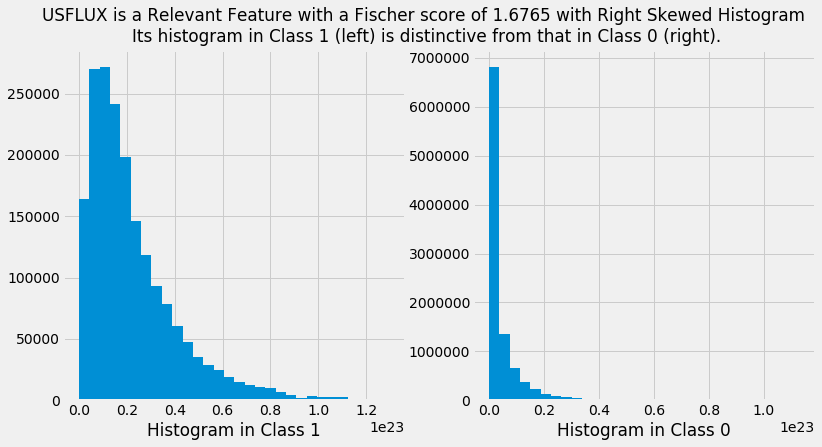

In [6]:
path_to_figure_data = './figure_data/'

feature = 'USFLUX'
ts_df = pd.read_csv(path_to_figure_data+feature+'_ts.csv') # three columns: 'all' column contains values of the feature USFLUX
# from all time series from all samples; 'pos' columns contains values from samples in Class 1 (flare);
# 'neg' column contains values from samples in Class 0 (no flare).
fischer_score = fischer_ranking_score(ts_df['all'],ts_df['pos'],ts_df['neg'])

import matplotlib.style as style
style.use('fivethirtyeight')
fig, axes = plt.subplots(1,2,figsize=(12,6)) # 1 row 3 columns
axes[0].hist(ts_df['pos'], bins=30)
axes[0].set_xlabel('Histogram in Class 1')
axes[1].hist(ts_df['neg'], bins=30)
axes[1].set_xlabel('Histogram in Class 0')
fig.suptitle(feature+''' is a Relevant Feature with a Fischer score of {:.4f} with Right Skewed Histogram 
Its histogram in Class 1 (left) is distinctive from that in Class 0 (right).'''.format(fischer_score))
plt.show()

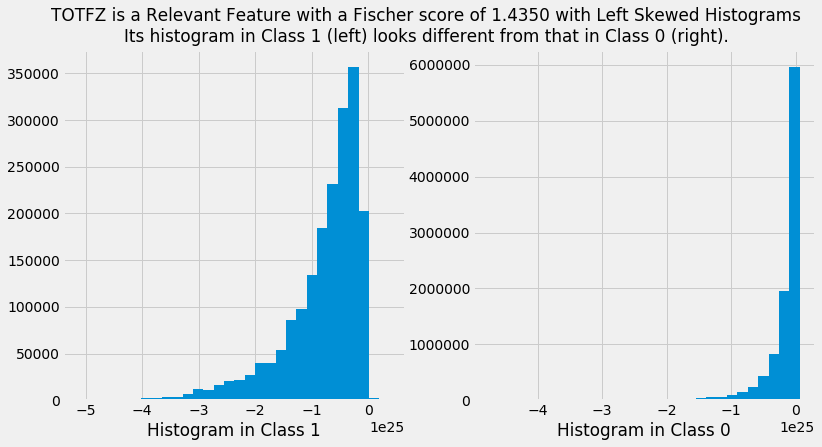

In [7]:
feature = 'TOTFZ'
ts_df = pd.read_csv(path_to_figure_data+feature+'_ts.csv') # three columns: 'all' column contains values of the feature USFLUX
# from all time series from all samples; 'pos' columns contains values from samples in Class 1 (flare);
# 'neg' column contains values from samples in Class 0 (no flare).
fischer_score = fischer_ranking_score(ts_df['all'],ts_df['pos'],ts_df['neg'])

import matplotlib.style as style
style.use('fivethirtyeight')
fig, axes = plt.subplots(1,2,figsize=(12,6)) # 1 row 3 columns
axes[0].hist(ts_df['pos'], bins=30)
axes[0].set_xlabel('Histogram in Class 1')
axes[1].hist(ts_df['neg'], bins=30)
axes[1].set_xlabel('Histogram in Class 0')
fig.suptitle(feature+''' is a Relevant Feature with a Fischer score of {:.4f} with Left Skewed Histograms
Its histogram in Class 1 (left) looks different from that in Class 0 (right).'''.format(fischer_score))
plt.show()

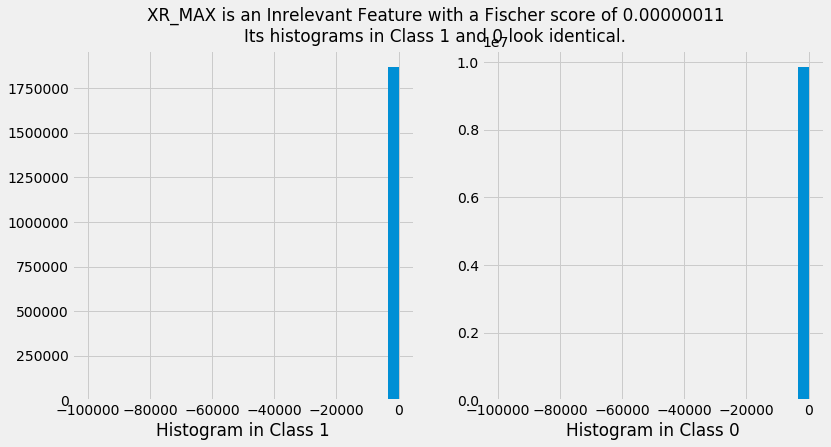

In [8]:
feature = 'XR_MAX'
ts_df = pd.read_csv(path_to_figure_data+feature+'_ts.csv') # three columns: 'all' column contains values of the feature USFLUX
# from all time series from all samples; 'pos' columns contains values from samples in Class 1 (flare);
# 'neg' column contains values from samples in Class 0 (no flare).
fischer_score = fischer_ranking_score(ts_df['all'],ts_df['pos'],ts_df['neg'])
fig, axes = plt.subplots(1,2,figsize=(12,6)) # 1 row 3 columns
axes[0].hist(ts_df['pos'], bins=30)
axes[0].set_xlabel('Histogram in Class 1')
axes[1].hist(ts_df['neg'], bins=30)
axes[1].set_xlabel('Histogram in Class 0')
fig.suptitle(feature+''' is an Inrelevant Feature with a Fischer score of {:.8f}
Its histograms in Class 1 and 0 look identical.'''.format(fischer_score))
plt.show()

After dropping inrelevant features, we move to examine the physical defintions of all features and find that some of them are related to each other by their definitions. These related features together would provide duplicate information. One physical relation allows us to drop one of the related features. After droping inrelevant and duplicate features, we end up with 14 selected features. All the details are explained in the jupyternotebook called 'Feature-Curation'. Next, we move onto feature scaling.

## Scaling Features

We have three different stratigies for feature scaling depending on the shapes of their histograms.

* Right skewed feature:

    * $ y = \ln(x-x_\mathrm{min} +1) $, where $x_\mathrm{min}$ is the minimal value of this feature in the combined (training and validation) data. We will separate the data into training and validation later.
    * $ {y-\bar y\over \sigma_y}$, where $\bar y$ is the mean of $y$ in the combined (training & validation) data.

* Left skewed feature:

    * $y=\ln(x_\mathrm{max}-x +1)$
    * ${y-\bar y \over \sigma_y}$,
where $\bar y$ and $\sigma_y$ are the mean and standard deviation of $y$.

* Non-skewed feature:

    $ {x-x_\mathrm{mean}\over \sigma_x}$
    
### Extreme Outliers
For features with extreme outliers, we use robust statistical quantitites, median and IQR, to replace mean and std in the equations above.

## Filling NaNs:

In astronomic observations, NaNs are sometimes due to the lack of observations when the features are too small for the telescope to detect. Assuming that is the case, we fill NaNs with zero. 

I use `np.nan_to_num()` function on the scaled feature, which converts nan to zero and positive infinity to large positive finite value, negative infinity to very negative finite value. This may not serve the right purpose. 

The cell below defines the function that we use to scale features and fill NaNs. We run `feature_curation.py` to convert all json files into .npy files with features selected and scaled & NaNs filled. The timeseries of features are stored in a file called `X_scaled.npy`, while the corresponding target outputs are store in a file called `y.npy`. We will read them in later for training our models. 

In [6]:
# function that scales features and fills NaNs according to the strategies described above.
def scale_features(X, selected_features, nan_to=0.0):
    X_copy = X.copy() # make a copy of X to avoid change X itself
    for i in range(0,len(selected_features)):
        feature = selected_features[i] # str, feature name
        # right skewed with extreme outliers
        if feature in right_skewed_features_with_ol:
            x_min, y_median, y_IQR = scale_params_right_skewed.loc[['x_min','y_median','y_IQR'],feature]
            x = X[:,:,i] # n_sample x time_steps x 1
            y = np.log(x - x_min + 1.0)
            z = (y - y_median)/y_IQR
            X_copy[:,:,i] = np.nan_to_num(z,nan=nan_to)
        # right skewed without extreme outliers
        elif feature in right_skewed_features_without_ol:
            x_min, y_mean, y_std = scale_params_right_skewed.loc[['x_min','y_mean','y_std'],feature]
            x = X[:,:,i]
            y = np.log(x-x_min+1.0)
            z = (y - y_mean)/y_std
            X_copy[:,:,i] = np.nan_to_num(z,nan=nan_to) 
        # non_skewed features, they do not have extreme outliers
        elif feature in non_skewed_features:
            x_mean, x_std = scale_params_non_skewed.loc[['x_mean','x_std'],feature]
            x = X[:,:,i]
            X_copy[:,:,i] = np.nan_to_num((x - x_mean)/x_std,nan=nan_to) 
        else:
            print(feature+' is not found, and thus not scaled.')

    return X_copy

# Feature Curation (Time-Saving Version)

The time-consuming version above requires a lot of manual observation and understanding of the physical features. When the schedule is tight, we take use of scikit-learn.preprocessing to preprocess our data quickly.

Below I design a class `FeatureCurator` which takes in a 3D data array, `X_3D`,  of the shape (`n_samples`, `time_steps`, `num_features`) and expands it to 2D array of the shape (`n_samples`$\times$`time_steps`, `num_features`). I design a number of functions which carry out different sorts of transformations on each feature. I recommend to do the transformations in the following order

* `.fill_nan()` fills NaNs using linear regression iteratively. Details of this method is explained on Page 3 of [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/pdf/nihms267760.pdf).

* `.clip_outlier()` collapses extreme large (or small) values onto `median`+`out_num`$\times$ `IQR` (or `median` + `out_num`$\times$`IQR`).

* `.power_transform()` executes Yeo-Johnson transformation to make the distribution of each feature more Gaussian like.

* `.min_max_scaler()` squeezes the values into the range (0, 1)

* `.back_to_3D()` reshapes the 2D array back to its original shape (`n_samples`, `time_steps`, `num_features`).

The recommended lines to execute feature curation is
* `X = FeatureCurator(X_3D)` 
* `X.fill_nan().power_transform().min_max_scaler().back_to_3D()`
* `X = X.data` 


X will be a np.ndarray ready for training the model.

In [11]:
# Packages for filling NaNs iteratively using linear regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Package for yeo-johnson transformation, supposed to cure skewness and normalize the data
from sklearn.preprocessing import PowerTransformer
# Scale a feature to [0,1] range by (x-x_min)/(x_max-x_min)
from sklearn.preprocessing import MinMaxScaler
# calculate Interquantile Range 
from scipy.stats import iqr 


class FeatureCurator():
    def __init__(self, X_3D):
        self.data = np.array(X_3D)
        self.n_samples = self.data.shape[0]
        self.time_steps = self.data.shape[1]
        self.num_features = self.data.shape[2]
        self.data_expand = self.data.reshape(-1, self.num_features)
    
    # fill in nan using linear regression iteratively
    def fill_nan(self):
        self.data_expand = IterativeImputer().fit_transform(self.data_expand)
        return self
    
    # clip extreme outliers
    def clip_outlier(self, out_num=8.0):
        nan_cnt = np.isnan(self.data_expand).sum()
        if nan_cnt >0:
            print('''There are nan in the data. Therefore,.clip_outlier() is not executed.\n Use .fill_nan() first before .clip_outlier().''')
            pass
        else:
            IQR = iqr(self.data_expand,axis=0)
            median = np.median(self.data_expand,axis=0)
            self.data_expand = np.clip(self.data_expand, median-out_num*IQR, median+out_num*IQR)
            return self
    
    # yeo-johnson transformation aiming at curing skewness and non-gaussianess
    # the transformation is applied to each column (feature) independently
    def power_transform(self):
        self.data_expand = PowerTransformer().fit_transform(self.data_expand)
        return self
    
    # squeeze the values of each feature into the range [0,1]
    def min_max_scaler(self):
        self.data_expand = MinMaxScaler().fit_transform(self.data_expand)
        return self
    
    # reshape the expanded 2D data_expand of shape(n_samples*time_steps, num_features)
    # back to the 3D shape(n_samples, time_steps, num_features)
    def back_to_3D(self):
        self.data = self.data_expand.reshape(self.n_samples,self.time_steps, self.num_features)
        return self

# Dealing with Imbalanced Classes 

###  Design a loss function: 

Most of the samples in the training data do not have flares (y=0), and thus the training data is imbalanced between positive class (y=1) and negative class (y=0). We need to design a loss function which assigns more penalty when the network misclassifies the positive class (i.e. False Negative). $\alpha>1$ is the penalty for false negative.

  * if y_true = 1, focal_loss = $-\alpha\ln(y_\mathrm{pred})$

  * otherwise, focal_loss = $-\ln(1-y_\mathrm{pred})$
  
**However this weighted loss function does not work well. It grows instead of decreases with batch (and epoch), strange!**. Another way to deal with imbalanced classes is to upsample the minor class.

### Upsampling Minor Class and Downsampling the major class

We will design a function which upsamples the minor class and downsamples the major class while keeping the total number of samples unchanged.

**However, this resampling strategy does not seem to improve the F1 score either.**
     

### F1 score is a suitable metric, since it is robust to the imbalance between Class 1 and 0:
$F_1 = {2\over \mathrm{precision}^{-1} + \mathrm{sensitivity}^{-1}}$, 
        where 
    
$ \mathrm{precision} = {\mathrm{True Positive}\over \mathrm{predicted Positive}}$
    
$ \mathrm{sensitivity} = {\mathrm{True Positive}\over \mathrm{actual Positive}}$



Below, we first design our weighted loss function.

In [12]:
'''Loss function suitable for imbalanced classes: weighted_bce_with_gamma'''
# FN_penalty = alpha, FP_penalty = 1-alpha
# targets are y_true, inputs are y_pred

# focal loss designed for the case when the last layer of the networ has two neurons
# with softmax activation
def focal_loss_softmax(targets, outputs, fn_penalty, gamma):    
#     targets = K.variable(targets) # these two lines are for the purpose of examining whether
#     outputs = K.variable(outputs) # focal_loss_softmax returns the correct answer. Comment
#     weights = K.variable([1.0-alpha,alpha]) # them away when used for training the model
    weights = [1.0, fn_penalty] # false negative penalty >1.0
    cce_weights = K.categorical_crossentropy(targets*weights, outputs)
    wce = K.mean(cce_weights)
#     y_pred = K.max(targets*outputs,axis=1) 
#     wce = K.mean(K.pow((1.0-y_pred), gamma)*cce_weights)
    return wce

# need a proper way to wrap the function 
from functools import partial, update_wrapper
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

# wrapped focal loss
wrapped_focal_loss = wrapped_partial(focal_loss_softmax, fn_penalty=np.sqrt(2.0), gamma=2.0)


Design a function upsampling minor class while downsampling major class.

In [13]:
from sklearn.utils import resample, shuffle

def balance_classes(X,y):
    '''
    Arguments: X--input features of the shape (n_sample, time_steps, num_features)
               y--target outputs of the shape (n_sample, 2)
               if y[i] = [1,0] means Class 0 (no flare)
               if y[i] = [0,1] means Class 1 (flare)
    Operation: Upsample minor class and Downsample major class keeping n_sample unchanged
    Returns: X_balanced, y_balanced of the same shapes as X and y
    '''
    class_0_index = (y[:,0] == 1)
    class_1_index = (y[:,1] == 1)
    num_0 = class_0_index.sum()
    num_1 = class_1_index.sum()
    tot_num = num_0 + num_1
    half_num = int(tot_num/2)
    another_half_num = tot_num - half_num
    
    X_class_0 = X[class_0_index]
    X_class_1 = X[class_1_index]
    
    X_class_0_resampled = resample(X_class_0, n_samples=half_num, random_state=10)
    X_class_1_resampled = resample(X_class_1, n_samples=another_half_num, random_state=0)
    X_resampled = np.concatenate((X_class_0_resampled,X_class_1_resampled),axis=0)
    
    class_0_resampled = np.tile(np.array([1,0]),(half_num,1))
    class_1_resampled = np.tile(np.array([0,1]),(another_half_num,1))
    y_resampled = np.concatenate((class_0_resampled, class_1_resampled), axis=0)
    
    X_shuffled, y_shuffled = shuffle(X_resampled, y_resampled)
    return  X_shuffled, y_shuffled
    

Design a metric robust to class imbalancement.

In [14]:
'''Metric suitable for imbalanced classes: f1_score'''
# Sensitivity = true_positivies/actual_positives = tp/(tp+fn)
# tp is true positive, fn is false negative
# sensitivity is also called 'recall', or 'true positive rate'
def sensitivity(y_true, y_pred):
    y_pred = K.clip(y_pred, 0, 1)
    true_positives = K.sum(K.round(y_true * y_pred))
    # K.clip(x,a,b) x is a tensor, a and b are numbers, clip converts any element of x falling
    # below the range [a,b] to a, and any element of x falling above the range [a,b] to b.
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    # K.epsilon >0 & <<< 1, in order to avoid division by zero.
    sen = recall = true_positives / (possible_positives + K.epsilon())
    return sen

# Precision = true_positives/predicted_positives = tp/(tp+fp)
# tp is true positive, fp is false positive
def precision(y_true, y_pred):
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    prec = true_positives / (predicted_positives + K.epsilon())
    return prec

# f1 = 2/((1/precision) + (1/sensitivity))
def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    sen = sensitivity(y_true, y_pred)
    f1 = 2*((prec*sen)/(prec + sen + K.epsilon()))
    return f1

# Building Models

Long Short Term Memory (LSTM) networks are the state of art for dealing with time series. We build two different architectures:
* One with two layers of LSTM.
* The other with two layers of Bidirectional LSTM (BiLSTM).

Note: Bidirectional LSTM allows information to flow both directions, while the conventional LSTM only allows information to flow from 'earlier' to 'later'.

In [15]:
# use tensorflow.keras to build our neural networks
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier # a model wrapper for cross validation
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.layers import Flatten, Activation 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
FLOAT_TYPE = 'float64'
K.set_floatx(FLOAT_TYPE)


# Define a nonlinear activation Function
# Mish: self-regularized activation function out-performs ReLU heuristically
# https://arxiv.org/pdf/1908.08681v1.pdf
# softplus(x) = ln(1+e^x)
# mish(x) = x*tanh(softplux(x))
def mish(x):
    return x*K.tanh(K.softplus(x))


# model 1: two lstm layers
def classifier(hidden_size, time_steps, feature_num, learning_rate, use_weighted_loss, dropout=0.5):
    model = Sequential()
    model.add(LSTM(units=hidden_size, input_shape=(time_steps,feature_num), return_sequences=True))
    model.add(LSTM(units=hidden_size, return_sequences=True))
    model.add(Dropout(dropout)) # against overfitting

    #TimeDistributed(layerX) assigns one layerX to each hidden memory cell (neuron) in the preceding LSTM layer
    #Make sure the preceding LSTM has its return_sequences=True, meaning output for every timestep
    model.add(TimeDistributed(Dense(int(hidden_size/2), activation=mish)))

    # Flatten takes input (batch_size, any size here) to output (batch_size, -1)
    # Flatten is needed here to get the input read for the following fully-connected (Dense) layer.
    model.add(Flatten())
    model.add(Dense(y_dim)) # Dense layer has y_dim=2 neurons.
    model.add(Activation('softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if use_weighted_loss:
        model.compile(loss=wrapped_focal_loss, optimizer=optimizer, metrics=[f1_score])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[f1_score])
    return model

# model2: replace the lstm layers in model 1 by two bidirectional lstm layers
def classifier_bidirection(hidden_size, time_steps, feature_num, learning_rate, use_weighted_loss, dropout=0.5):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hidden_size,return_sequences=True),input_shape=(time_steps,feature_num)))
    model.add(Bidirectional(LSTM(units=hidden_size,return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(int(hidden_size/2), activation=mish)))
    model.add(Flatten()) 
    model.add(Dense(y_dim)) 
    model.add(Activation('softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if use_weighted_loss:
        model.compile(loss=wrapped_focal_loss, optimizer=optimizer, metrics=[f1_score])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[f1_score])
    return model

# Selecting Models by Cross Validation

* Split data into train and test sets. 
* Use the train set for cross validation.
* Adjust `batch_size`, `num_epoch` (total number of epochs for training), and `initial_lr` (initail learning rate) to reach better F1 scores.
* We find both models, LSTM & BiLSTM with A
ttention, achieve similar F1 scores. We decide to keep both of them and combine them into an ensumble.

Below, we first read data from json file and convert them to np.ndarray and the right shape.

In [16]:
from read_json import convert_json_data_to_nparray

path_to_data = '../input'
file_name = "fold"+str(3)+"Training.json"
fname = os.path.join(path_to_data,file_name)

# Read in time series of 25 features into all_input, correct class labels into labels, and 
# the unique ids for all data samples into ids. 
all_input, class_labels, ids = convert_json_data_to_nparray(path_to_data, file_name)

# Change X and y to numpy.ndarray in the correct shape.
X_all = np.array(all_input)
y_all = np.array([class_labels]).T

We use sklearn.model_selection.StratifiedShuffleSplit to split the data set into train and test sets. This method makes the train and test sets to have equally balanced classes. Because the train set will later be used for cross validation, I will call the inputs and labels for cross validation `X` and `y`.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# test set is 30% of the total data set.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(X_all, y_all)

for cv_index, test_index in sss.split(X_all,y_all):
    X, X_test = X_all[cv_index], X_all[test_index]
    y, y_test = y_all[cv_index], y_all[test_index] 

labels = y.copy()

In [18]:
"""
# these two lines below read in scaled data from .npy files which have been scaled using the 
# time-consuming version of Feature Curation described above.
# read in scaled features and targeted (correct) outputs
use_time_saving_feature_curation = False
X = np.load('../input/X_scaled.npy')
y = np.load('../input/y.npy')
labels = y.copy()
print('There are {} NaN in y.'.format(np.isnan(y).sum()))
print('There are {} NaN in X.'.format(np.isnan(X).sum()))
"""

# use the time saving version of feature curation
use_time_saving_feature_curation = True

# upsampling minor class (Class 1) and downsampling major class (Class 0) 
# so that they each occupy 50% of the training data.
# we decide not to use it either, because we find this does a worse job on the F1 score of the validation.
use_balance_classes = False

# since we find the weighted loss function we design works worse than categorical cross entropy
# the weighted loss function keeps growing after only a few epochs.
use_weighted_loss = False 

# the target output y=0 for no solar flare and y=1 for solar flare
# the OneHotEncoder converts y=[0] to y=[1,0] and coverts y=[1] to y=[0,1]
# the new format of y is suitable for softmax 
from sklearn.preprocessing import OneHotEncoder

# one-hot encode y, [0] --> [1,0]; [1] --> [0, 1]
onehot_encoder = OneHotEncoder(sparse=False)
y = np.asarray(onehot_encoder.fit_transform(labels), dtype=FLOAT_TYPE)
y_dim = np.shape(y)[1] # y_dim =2 after OneHotEncoder()


# Set some hyperparameters
num_epochs = 100
time_steps = X.shape[1] 
batch_size = 256 # int(n_sample/30) # was 256 for fold3
feature_num = X.shape[2] 
hidden_size = feature_num
initial_lr = 0.001 # initial learning for optimizer, default for Adam is 0.001; 
# SGD keeps constant learning rate with default value 0.01

# Split X, y into training and validation sets
# define k-fold cross validation test harness
seed = 10 # random seed for reproductivity

n_splits = 5 # split data set into 0.2 validation & 0.8 training for cross validation.

# sklearn.model_selection.StratifiedKFold splits data while preserving percentage of samples for each class
# sklearn.model_selection.StratifiedKFold provides indices
# for splitting data set and cross validation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

cross validation for the bidirectional lstm model `classifier_bidirection`.

In [30]:
# since StratifiedKFold returns indices, NO need to pass in .split(X,y), 
# instead passing in .split(y,y) is enough
cv_count = 0
for train, val in kfold.split(np.asarray(labels), np.asarray(labels)):
    if cv_count >0: # only run one iteration of cross validation for the purpose of exhibition.
        break
    X_train = X[train]
    X_val = X[val]
    y_train = y[train]
    y_val = y[val]
    
    '''
    If we use the time-saving version of feature curation, featured are not yet curated 
    beforehand and thus we need to do feature curation here.
    '''
    if use_time_saving_feature_curation:
        
        # feature curation for the training set
        X_train_FC = FeatureCurator(X_train)
        X_train_FC.fill_nan().power_transform().min_max_scaler().back_to_3D()
        X_train = X_train_FC.data
        
        # feature curation for the validation set
        X_val_FC = FeatureCurator(X_val)
        X_val_FC.fill_nan().power_transform().min_max_scaler().back_to_3D()
        X_val = X_val_FC.data
        
    '''
    For X_train and y_train: upsample minor and downsample major class 
    so that each class each occupies 50% of the X_train and y_train.
    Make sure you do not do this to X_val and y_val
    '''
    if use_balance_classes:
        X_train, y_train = balance_classes(X_train, y_train)
    
    # y does not need to be cured.
    
    # train and validate
    clf = KerasClassifier(classifier_bidirection, hidden_size=hidden_size, time_steps=time_steps, 
                          feature_num=feature_num,learning_rate = initial_lr, use_weighted_loss=use_weighted_loss,\
                          epochs=num_epochs,batch_size=batch_size, verbose=1, validation_data=(X_val,y_val))
    history = clf.fit(X_train, y_train)
    cv_count += 1

Train on 15123 samples, validate on 3781 samples
Epoch 1/100
15123/15123 [==============================] - 19s 1ms/sample - loss: 0.3260 - f1_score: 0.8582 - val_loss: 0.2610 - val_f1_score: 0.8769
Epoch 2/100
15123/15123 [==============================] - 13s 861us/sample - loss: 0.2501 - f1_score: 0.8886 - val_loss: 0.3189 - val_f1_score: 0.8484
Epoch 3/100
15123/15123 [==============================] - 13s 875us/sample - loss: 0.2431 - f1_score: 0.8925 - val_loss: 0.2990 - val_f1_score: 0.8615
Epoch 4/100
15123/15123 [==============================] - 13s 865us/sample - loss: 0.2471 - f1_score: 0.8924 - val_loss: 0.3368 - val_f1_score: 0.8398
Epoch 5/100
15123/15123 [==============================] - 13s 868us/sample - loss: 0.2346 - f1_score: 0.8952 - val_loss: 0.2628 - val_f1_score: 0.8848
Epoch 6/100
15123/15123 [==============================] - 13s 869us/sample - loss: 0.2341 - f1_score: 0.8949 - val_loss: 0.2876 - val_f1_score: 0.8719
Epoch 7/100
15123/15123 [================

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])


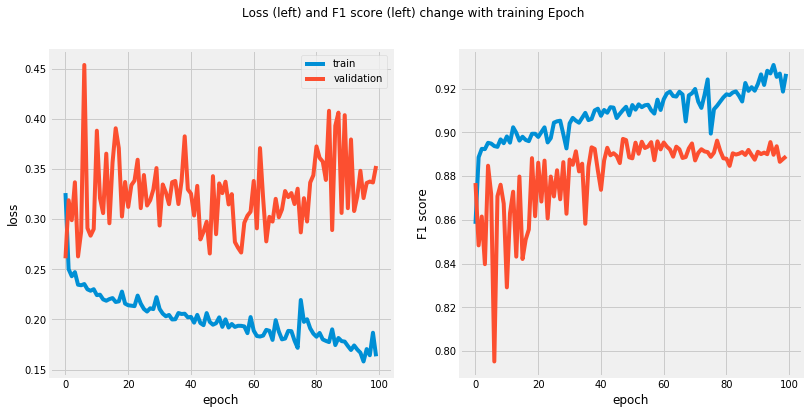

In [31]:
# list all data in history
print(history.history.keys())
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train','validation'], loc='upper right')
axes[1].plot(history.history['f1_score'])
axes[1].plot(history.history['val_f1_score'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('F1 score')
fig.suptitle('Loss (left) and F1 score (left) change with training Epoch')
plt.show()

cross validation for the lstm model `classifier`.

In [19]:
# since StratifiedKFold returns indices, NO need to pass in .split(X,y), 
# instead passing in .split(y,y) is enough
cv_count = 0
for train, val in kfold.split(np.asarray(labels), np.asarray(labels)):
    if cv_count >0: # only run one iteration of cross validation for the purpose of exhibition.
        break
    X_train = X[train]
    X_val = X[val]
    y_train = y[train]
    y_val = y[val]
    
    '''
    If we use the time-saving version of feature curation, featured are not yet curated 
    beforehand and thus we need to do feature curation here.
    '''
    if use_time_saving_feature_curation:
        
        # feature curation for the training set
        X_train_FC = FeatureCurator(X_train)
        X_train_FC.fill_nan().power_transform().min_max_scaler().back_to_3D()
        X_train = X_train_FC.data
        
        # feature curation for the validation set
        X_val_FC = FeatureCurator(X_val)
        X_val_FC.fill_nan().power_transform().min_max_scaler().back_to_3D()
        X_val = X_val_FC.data
        
    '''
    For X_train and y_train: upsample minor and downsample major class 
    so that each class each occupies 50% of the X_train and y_train.
    Make sure you do not do this to X_val and y_val
    '''
    if use_balance_classes:
        X_train, y_train = balance_classes(X_train, y_train)
    
    # train and validate
    clf = KerasClassifier(classifier, hidden_size=hidden_size, time_steps=time_steps, 
                          feature_num=feature_num,learning_rate = initial_lr, use_weighted_loss=use_weighted_loss,\
                          epochs=num_epochs,batch_size=batch_size, verbose=1, validation_data=(X_val,y_val))
    history = clf.fit(X_train, y_train)
    cv_count += 1

Train on 15123 samples, validate on 3781 samples
Epoch 1/100
15123/15123 [==============================] - 17s 1ms/sample - loss: 0.3512 - f1_score: 0.8459 - val_loss: 0.4120 - val_f1_score: 0.7606
Epoch 2/100
15123/15123 [==============================] - 13s 843us/sample - loss: 0.2486 - f1_score: 0.8876 - val_loss: 0.3410 - val_f1_score: 0.8139
Epoch 3/100
15123/15123 [==============================] - 13s 833us/sample - loss: 0.2476 - f1_score: 0.8862 - val_loss: 0.2959 - val_f1_score: 0.8600
Epoch 4/100
15123/15123 [==============================] - 13s 843us/sample - loss: 0.2365 - f1_score: 0.8926 - val_loss: 0.2932 - val_f1_score: 0.8621
Epoch 5/100
15123/15123 [==============================] - 13s 850us/sample - loss: 0.2342 - f1_score: 0.8946 - val_loss: 0.2543 - val_f1_score: 0.8771
Epoch 6/100
15123/15123 [==============================] - 13s 869us/sample - loss: 0.2479 - f1_score: 0.8868 - val_loss: 0.2738 - val_f1_score: 0.8818
Epoch 7/100
15123/15123 [================

15123/15123 [==============================] - 13s 846us/sample - loss: 0.2033 - f1_score: 0.9070 - val_loss: 0.4967 - val_f1_score: 0.8087
Epoch 55/100
15123/15123 [==============================] - 14s 899us/sample - loss: 0.2020 - f1_score: 0.9091 - val_loss: 0.4942 - val_f1_score: 0.8120
Epoch 56/100
15123/15123 [==============================] - 14s 902us/sample - loss: 0.2038 - f1_score: 0.9074 - val_loss: 0.6085 - val_f1_score: 0.8135
Epoch 57/100
15123/15123 [==============================] - 13s 863us/sample - loss: 0.2070 - f1_score: 0.9092 - val_loss: 0.4934 - val_f1_score: 0.8097
Epoch 58/100
15123/15123 [==============================] - 13s 843us/sample - loss: 0.2015 - f1_score: 0.9067 - val_loss: 0.5368 - val_f1_score: 0.8101
Epoch 59/100
15123/15123 [==============================] - 13s 860us/sample - loss: 0.1997 - f1_score: 0.9081 - val_loss: 0.5692 - val_f1_score: 0.7902
Epoch 60/100
15123/15123 [==============================] - 13s 835us/sample - loss: 0.1997 - f

In [ ]:
# list all data in history
print(history.history.keys())
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train','validation'], loc='upper right')
axes[1].plot(history.history['f1_score'])
axes[1].plot(history.history['val_f1_score'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('F1 score')
fig.suptitle('Loss (left) and F1 score (left) change with training Epoch')
plt.show()

In [ ]:
# list all data in history
print(history.history.keys())
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['train','validation'], loc='upper right')
axes[1].plot(history.history['f1_score'])
axes[1].plot(history.history['val_f1_score'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('F1 score')
fig.suptitle('Loss (left) and F1 score (left) change with training Epoch')
plt.show()

# EarlyStopping during Cross Validation and Generating Model Ensemble

Stop training when the loss on the validation data stops improving. Save the trained models for later use.

In [ ]:
#stop training as the val_loss on the validation stops improve for 10 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

# train 5 models using cross validation
cv_cnt = 0
for train, val in kfold.split(np.asarray(labels), np.asarray(labels)):
    
    # assign train and validation data
    X_train = X[train]
    X_val = X[val]
    y_train = y[train]
    y_val = y[val]
    
    '''
    If we use the time-saving version of feature curation, featured are not yet curated 
    beforehand and thus we need to do feature curation here.
    '''
    if use_time_saving_feature_curation:
        
        # feature curation for the training set
        X_train_FC = FeatureCurator(X_train)
        X_train_FC.fill_nan().power_transform().min_max_scaler().back_to_3D()
        X_train = X_train_FC.data
        
        # feature curation for the validation set
        X_val_FC = FeatureCurator(X_val)
        X_val_FC.fill_nan().power_transform().min_max_scaler().back_to_3D()
        X_val = X_val_FC.data
        
    '''
    For X_train and y_train: upsample minor and downsample major class 
    so that each class each occupies 50% of the X_train and y_train.
    Make sure you do not do this to X_val and y_val
    '''
    if use_balance_classes:
        X_train, y_train = balance_classes(X_train, y_train)
    
    # define the model
    model = classifier(hidden_size=hidden_size, time_steps=time_steps, feature_num=feature_num, \
                       learning_rate = initial_lr, use_weighted_loss=use_weighted_loss)
    
    # train the model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, 
                        callbacks=[callback], validation_data=(X_val,y_val))
    
    # save the trained model
    model.save('model_cv_'+str(cv_cnt)+'.h5')
    
    # count the number of cross validation
    cv_count += 1

# Testing Models

Make predictions for the test data and compare with the target (correct) answers. We achieve F1 score about 

# Conclusion

Solar flares may lead to severe damages to space equipment and astronauts, making it necessary to predict solar flares. This project aims at predicting solar flares within the next 24 hours based on time series of magnetic parameters measured on the solar disk for a duration of 12 hours. 

We build neural networks based on LSTM which achieve F1 score about 0.95. 

In the future, we plan to apply contextual decomposition to interprete our results, in order to understand the relations between the solar magnetic parameters and solar flares. Contextual decomposion is a neural network interpretor tool developed recently (2018, 2019).